In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:

$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

In [ ]:
# Code to install Unsloth, Triton, Torch etc
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth
!pip install tyro

In [ ]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os
major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = (major_version >= 8)
from inspect import currentframe as _C, getframeinfo
_F = lambda c: getframeinfo(c).lineno # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m") # Red colored warnings

# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""

def assert_same(x, y, line, dtype):
    assert(x.dtype == dtype)
    try: torch.testing.assert_close(x, y, check_stride = True)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

Standard Loss: 10.562500
Custom Loss: 10.562500
Loss Difference: 0.000000


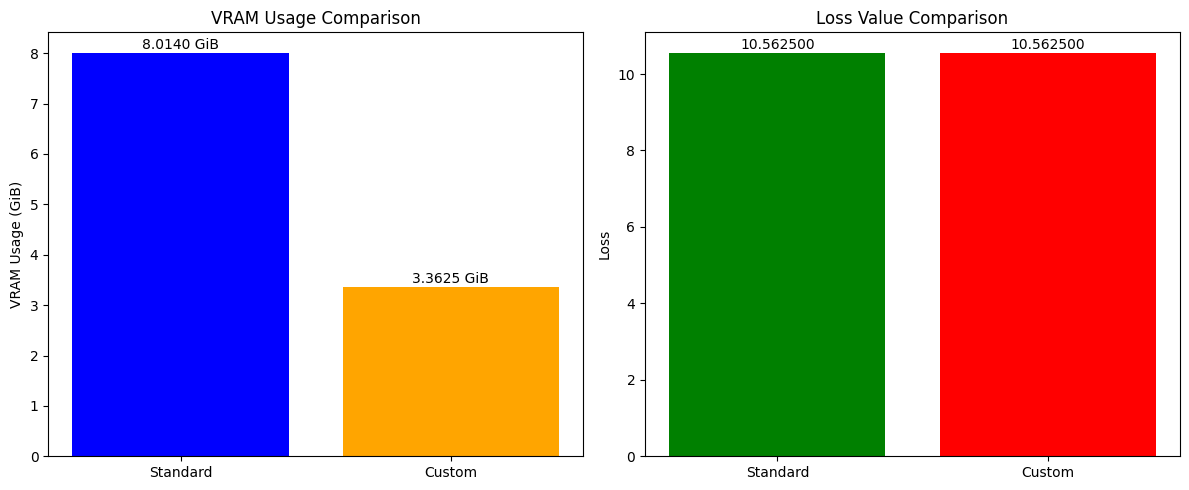

In [ ]:
import torch
import time
import matplotlib.pyplot as plt  # For plotting

def transformation_function(batch, linear, labels):
    x = linear(batch)  # Keep in bfloat16, no upcasting
    from torch.nn import CrossEntropyLoss
    down_projection_function = CrossEntropyLoss(reduction="mean")
    loss = down_projection_function(x.view(-1, x.shape[-1]), labels.view(-1))
    return loss

class MemoryEfficientLinear(torch.autograd.Function):
    @staticmethod
    def forward(ctx, X, linear, labels, forward_function):
        num_chunks = 2
        chunks = X.chunk(num_chunks, dim=0)
        split_sizes = [chunk.size(0) * X.size(1) for chunk in chunks]
        labels_flat = labels.view(-1)
        labels_chunks = torch.split(labels_flat, split_sizes, dim=0)

        sum_loss = 0.0
        total_elements = 0
        elements_in_chunks = []
        for x_chunk, labels_chunk in zip(chunks, labels_chunks):
            x_chunk = x_chunk.detach().requires_grad_(True)
            chunk_loss = forward_function(x_chunk, linear, labels_chunk)
            elements = labels_chunk.numel()
            sum_loss += chunk_loss * elements
            total_elements += elements
            elements_in_chunks.append(elements)

        final_loss = sum_loss / total_elements

        ctx.save_for_backward(X, labels)
        ctx.linear = linear
        ctx.forward_function = forward_function
        ctx.split_sizes = split_sizes
        ctx.elements_in_chunks = elements_in_chunks
        ctx.total_elements = total_elements
        ctx.num_chunks = num_chunks

        return final_loss

    @staticmethod
    def backward(ctx, dY):
        X, labels = ctx.saved_tensors
        linear = ctx.linear
        forward_function = ctx.forward_function
        split_sizes = ctx.split_sizes
        elements_in_chunks = ctx.elements_in_chunks
        total_elements = ctx.total_elements
        num_chunks = ctx.num_chunks

        X_chunks = X.chunk(num_chunks, dim=0)
        labels_flat = labels.view(-1)
        labels_chunks = torch.split(labels_flat, split_sizes, dim=0)
        dX = torch.zeros_like(X)
        dW = torch.zeros_like(linear.weight)
        dB = torch.zeros_like(linear.bias) if linear.bias is not None else None

        for i in range(num_chunks):
            x_chunk = X_chunks[i].clone().detach().requires_grad_(True)
            labels_chunk = labels_chunks[i]
            elements = elements_in_chunks[i]
            scale = dY * (elements / total_elements)
            with torch.enable_grad():
                chunk_loss = forward_function(x_chunk, linear, labels_chunk)
                grad_x, grad_w, grad_b = torch.autograd.grad(
                    chunk_loss,
                    (x_chunk, linear.weight, linear.bias),
                    grad_outputs=scale,
                    retain_graph=False,
                    allow_unused=False,
                )
            start_idx = i * x_chunk.size(0)
            end_idx = start_idx + x_chunk.size(0)
            dX[start_idx:end_idx] = grad_x
            dW += grad_w
            if grad_b is not None:
                dB += grad_b

        return dX, None, None, None

# Parameters
batch_size = 64
seq_len = 512
hidden_dim = 768
vocab_size = 32000
device = 'cuda'

# Create input and labels
input_data = torch.randn(batch_size, seq_len, hidden_dim,
                         dtype=torch.bfloat16, device=device, requires_grad=True)
labels = torch.randint(0, vocab_size, (batch_size, seq_len),
                       dtype=torch.long, device=device)

# Initialize linear layers with matching parameters
def create_linear():
    linear = torch.nn.Linear(hidden_dim, vocab_size, device=device)
    linear.weight = torch.nn.Parameter(linear.weight.to(torch.bfloat16))
    if linear.bias is not None:
        linear.bias.data = linear.bias.data.to(torch.bfloat16)
    return linear

linear_standard = create_linear()
linear_custom = create_linear()
linear_custom.load_state_dict(linear_standard.state_dict())

def standard_forward_backward():
    linear_standard.zero_grad()
    if input_data.grad is not None:
        input_data.grad.zero_()
    logits = linear_standard(input_data)
    loss = torch.nn.CrossEntropyLoss(reduction='mean')(
        logits.view(-1, vocab_size), labels.view(-1)
    )
    loss.backward()
    return loss.detach()

def custom_forward_backward():
    linear_custom.zero_grad()
    if input_data.grad is not None:
        input_data.grad.zero_()
    loss = MemoryEfficientLinear.apply(input_data, linear_custom, labels, transformation_function)
    loss.backward()
    return loss.detach()

# Warmup runs to avoid CUDA initialization overhead
for _ in range(2):
    standard_forward_backward()
    custom_forward_backward()

# Compute and compare loss values
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
loss_standard = standard_forward_backward().item()

torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
loss_custom = custom_forward_backward().item()

loss_diff = abs(loss_standard - loss_custom)

print(f"Standard Loss: {loss_standard:.6f}")
print(f"Custom Loss: {loss_custom:.6f}")
print(f"Loss Difference: {loss_diff:.6f}")

# Measure VRAM usage for Standard
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
standard_forward_backward()
vram_standard = torch.cuda.max_memory_allocated() / (1024**3)  # Convert bytes to GiB

# Measure VRAM usage for Custom
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
custom_forward_backward()
vram_custom = torch.cuda.max_memory_allocated() / (1024**3)  # Convert bytes to GiB

# Plot both graphs: VRAM usage and Loss values
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# VRAM Usage Bar Plot
implementations = ['Standard', 'Custom']
vram_usage = [vram_standard, vram_custom]
bars1 = axs[0].bar(implementations, vram_usage, color=['blue', 'orange'], edgecolor='none')
for bar in bars1:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.4f} GiB',
                ha='center', va='bottom')
axs[0].set_ylabel('VRAM Usage (GiB)')
axs[0].set_title('VRAM Usage Comparison')
axs[0].grid(False)

# Loss Value Bar Plot
loss_values = [loss_standard, loss_custom]
bars2 = axs[1].bar(implementations, loss_values, color=['green', 'red'], edgecolor='none')
for bar in bars2:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.6f}',
                ha='center', va='bottom')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss Value Comparison')
axs[1].grid(False)

plt.tight_layout()
plt.show()
